In [1]:
import sklearn
import numpy as np
import pandas as pd
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Read the data

In [2]:
df = pd.read_excel('default of credit card clients.xls', index_col = 0, header = 1)

In [3]:
df.rename(columns={'default payment next month':'default'}, inplace=True)

Encoding of categorical variables

In [4]:
df['EDUCATION'] = df['EDUCATION'].astype('category')
df['SEX'] = df['SEX'].astype('category')
df['MARRIAGE'] = df['MARRIAGE'].astype('category')

df=pd.concat([pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'), 
                  pd.get_dummies(df['SEX'], prefix='SEX'), 
                  pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                  df],axis=1)
df.drop(['EDUCATION'],axis=1, inplace=True)
df.drop(['SEX'],axis=1, inplace=True)
df.drop(['MARRIAGE'],axis=1, inplace=True)
df.head()

,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,SEX_1,SEX_2,MARRIAGE_0,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,689,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,0,0,1,0,0,0,0,0,1,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,0,0,1,0,0,0,0,0,1,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,0,0,1,0,0,0,0,1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Computed feature

In [5]:
pay_vars = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6']
df.insert(0, "DELAYED", (df[pay_vars] > 0).sum(axis=1))

Divide the data in a train and test set

In [6]:
data = np.array(df)
indices = df.columns
X_train, X_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size = 0.33, random_state = 42)
train_indices = indices[:-1]
X_train = pd.DataFrame(X_train, columns = train_indices)

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest


preprocessing = Pipeline([('scaler', StandardScaler()),
                          ('imputer', SimpleImputer())
                          ])


feature_selection = Pipeline([('SelectKBest', SelectKBest())])

PCA on subset of features

In [8]:
pca_indices = np.array(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'])

pca_features = X_train[pca_indices]
pca_features.head()

scale = StandardScaler()
pca_features = scale.fit_transform(pca_features)

pca = PCA()
pca_features = pca.fit_transform(pca_features)

pca_features.shape

(20100, 12)

In [9]:
components_indices = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9',
                'PC-10','PC-11','PC-12']

pca_df = pd.DataFrame(pca_features, columns=components_indices)
pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12
0,-0.909044,-0.069727,-0.150297,-0.066069,0.269318,-0.215425,-0.097656,0.864680,0.612199,-0.696648,-0.078467,-0.576010
1,0.920540,0.459320,-1.794198,1.016920,-0.070479,0.558647,-0.378851,0.039545,0.008158,0.056061,-0.003010,0.076591
2,-0.394301,-0.429958,0.129103,0.070549,-0.038202,-0.017841,0.022800,0.058345,-0.050358,0.000891,-0.007951,0.016560
3,3.024563,-0.781976,0.192176,0.137236,-0.110825,0.350901,-0.208844,-0.560366,0.064872,0.047916,-0.040938,-0.003264
4,-0.284117,-0.445485,0.205641,0.068262,-0.176627,-0.108807,-0.012813,0.573311,-0.043624,0.230517,0.030779,0.518507


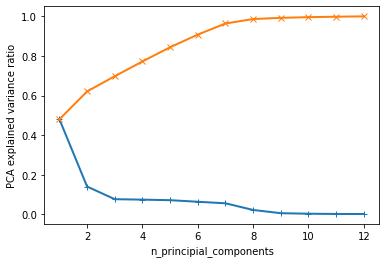

In [10]:
plt.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2,
    label="var_explained", linestyle='-'
)

plt.plot(
    np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), "x", linewidth=2, 
    label="cumulative_var_explained", linestyle='-'
)
plt.ylabel("PCA explained variance ratio")
plt.xlabel('n_principial_components')
plt.show()

In [11]:
X_train.drop(pca_indices,axis=1, inplace=True)
X_train = pd.concat((X_train, pca_df), axis = 1)

In [12]:
X_train.head()

,DELAYED,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,SEX_1,SEX_2,...,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12
0,0,0,0,0,1,0,0,0,1,0,...,-0.150297,-0.066069,0.269318,-0.215425,-0.097656,0.864680,0.612199,-0.696648,-0.078467,-0.576010
1,1,0,1,0,0,0,0,0,1,0,...,-1.794198,1.016920,-0.070479,0.558647,-0.378851,0.039545,0.008158,0.056061,-0.003010,0.076591
2,0,0,0,1,0,0,0,0,0,1,...,0.129103,0.070549,-0.038202,-0.017841,0.022800,0.058345,-0.050358,0.000891,-0.007951,0.016560
3,3,0,0,0,1,0,0,0,0,1,...,0.192176,0.137236,-0.110825,0.350901,-0.208844,-0.560366,0.064872,0.047916,-0.040938,-0.003264
4,1,0,0,0,1,0,0,0,1,0,...,0.205641,0.068262,-0.176627,-0.108807,-0.012813,0.573311,-0.043624,0.230517,0.030779,0.518507


In [13]:
X_copy = X_train
X_train = np.array(X_train)

In [14]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

In [15]:
param_grid = {
                'preprocessing__imputer__strategy' : ['mean'],
                'feature_selection__SelectKBest__k' : [15,16,17,18,19], 
                'classifier__penalty' : ['l1'], 
                'classifier__tol' : [1e-3],
                'classifier__C' : [0.01, 0.1, 1],
                'classifier__class_weight' : ['balanced'],
                'classifier__solver' : ['saga'],
                'classifier__max_iter' : [10000]
                }

Create validation folds

In [16]:
n_folds = 5

from sklearn.model_selection import KFold

def create_folds(X,y,n_folds):
    folds = []
    cv_object = KFold(n_splits = n_folds)
    for (train_indices, val_indices) in cv_object.split(X_train, y_train):
        folds.append((train_indices,val_indices))
    return folds

In [17]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit='f1', scoring=['accuracy', 'f1', 'roc_auc'] )
cv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


GridSearchCV(cv=[(array([ 4020,  4021,  4022, ..., 20097, 20098, 20099]),
                  array([   0,    1,    2, ..., 4017, 4018, 4019])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([4020, 4021, 4022, ..., 8037, 8038, 8039])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([ 8040,  8041,  8042, ..., 12057, 12058, 12059])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([12060, 12061, 12062, ..., 16077, 16078, 16079...
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__class_weight': ['balanced'],
                         'classifier__max_iter': [10000],
                         'classifier__penalty': ['l1'],
                         'classifier__solver': ['saga'],
                         'classifier__tol': [0.001],
                         'feature_selection__SelectKBest__k': [15, 1

In [18]:
results = cv.cv_results_
mean_train_score = results['mean_train_f1'][cv.best_index_]
std_train_score = results['std_train_f1'][cv.best_index_]
mean_cv_score = results['mean_test_f1'][cv.best_index_]
std_cv_score = results['std_test_f1'][cv.best_index_]

mean_cv_acc = results['mean_test_accuracy'][cv.best_index_]
std_cv_acc = results['std_test_accuracy'][cv.best_index_]

mean_cv_auc = results['mean_test_roc_auc'][cv.best_index_]
std_cv_auc = results['std_test_roc_auc'][cv.best_index_]


print('Training f1 {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation f1: {} +/- {}'.format(mean_cv_score, std_cv_score))
print('Cross-validation acc: {} +/- {}'.format(mean_cv_acc, std_cv_acc))
print('Cross-validation auc: {} +/- {}'.format(mean_cv_auc, std_cv_auc))

print('Best estimator:')
print(cv.best_estimator_)

Training f1 0.5287772792205132 +/- 0.002491309691332813
Cross-validation f1: 0.5292689005143351 +/- 0.010162726303148338
Cross-validation acc: 0.7702487562189054 +/- 0.008915889291282692
Cross-validation auc: 0.7509208907549729 +/- 0.01118909557493362
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('imputer', SimpleImputer())])),
                ('feature_selection',
                 Pipeline(steps=[('SelectKBest', SelectKBest(k=17))])),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=10000, penalty='l1', solver='saga',
                                    tol=0.001))])


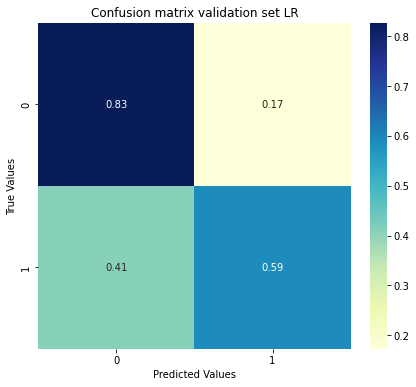

In [19]:
for _, val_indices in folds:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    X = X_train[val_indices]
    y = y_train[val_indices]
    y_pred = cv.best_estimator_.predict(X)
    labels = y
    cm = confusion_matrix(y, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.title("Confusion matrix validation set LR")
    plt.show(block=False)
    break
   
    

Prediction only dominant class: ROC AUC=0.500
Model: ROC AUC=0.760


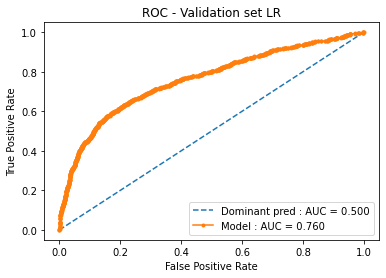

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


for _ ,val_indices in folds:
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_train[val_indices]))]
    X = X_train[val_indices]
    y = y_train[val_indices]
    lr_probs = cv.best_estimator_.predict_proba(X)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(y, lr_probs)
    # summarize scores
    print('Prediction only dominant class: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dominant pred : AUC = %.3f' % (ns_auc))
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model : AUC = %.3f' % (lr_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend(loc = 'lower right')
    pyplot.title("ROC - Validation set LR")
    # show the plot
    pyplot.show()
    break

Selected variables

In [21]:
k = cv.best_estimator_.named_steps['feature_selection']['SelectKBest'].k

a = cv.best_estimator_.named_steps["feature_selection"]["SelectKBest"].scores_
ind = np.argpartition(a, -k)[-k:][::-1]
a[ind]
X_copy.columns[ind]


Index(['DELAYED', 'PAY_0', 'PAY_6', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_2',
       'LIMIT_BAL', 'PC-2', 'SEX_2', 'EDUCATION_1', 'SEX_1', 'EDUCATION_2',
       'EDUCATION_3', 'PC-8', 'EDUCATION_5', 'PC-1'],
      dtype='object')

#### Finding optimal cutoff
By maximizing precision-recall. Economics of the problem is not considered. This threshold will give the lowest false positive rate and the highest true positive rate.

In [22]:
 from sklearn.metrics import roc_curve
 preds =cv.best_estimator_.predict_proba(X_train)[:,1]

 fpr, tpr, thresholds = roc_curve(y_train, preds)
 optimal_idx = np.argmax(tpr - fpr)
 optimal_threshold = thresholds[optimal_idx]

 optimal_threshold



0.4817303861143862

#### Testing model

In [23]:
X_test = pd.DataFrame(X_test, columns = train_indices)

Preprocessing

In [24]:
pca_indices = np.array(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'])

pca_features = X_test[pca_indices]
pca_features.head()

scale = StandardScaler()
pca_features = scale.fit_transform(pca_features)

pca_features = pca.fit_transform(pca_features)

components_indices = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9',
                'PC-10','PC-11','PC-12']

pca_df = pd.DataFrame(pca_features, columns=components_indices)
pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12
0,-1.312954,-0.165650,0.004028,-0.045705,-0.010804,-0.031890,0.017360,-0.174981,0.005189,0.016967,-0.000156,-0.001803
1,1.999618,-0.931094,-0.144955,-0.008154,-0.005640,-0.074735,-0.060257,0.387825,0.051836,0.004073,0.089311,-0.056549
2,0.757705,-0.598073,0.045267,-0.092921,-0.036272,-0.077223,-0.005224,-0.297939,-0.039414,0.003613,-0.004138,-0.003856
3,-1.133171,0.083491,0.047366,0.046161,-0.394538,-0.032984,-0.181101,0.063852,0.088822,-0.032296,-0.046352,0.019506
4,-0.400414,-0.589694,-0.077626,0.003955,0.079980,-0.088785,-0.087256,0.609177,-0.302591,-0.119636,0.177198,0.161705


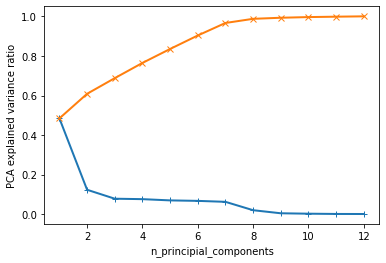

In [25]:
plt.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2,
    label="var_explained", linestyle='-'
)

plt.plot(
    np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), "x", linewidth=2, 
    label="cumulative_var_explained", linestyle='-'
)
plt.ylabel("PCA explained variance ratio")
plt.xlabel('n_principial_components')
plt.show()

In [26]:
X_test.drop(pca_indices,axis=1, inplace=True)
X_test = pd.concat((X_test, pca_df), axis = 1)

In [27]:
X_test.head()

,DELAYED,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,SEX_1,SEX_2,...,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12
0,0,0,0,1,0,0,0,0,1,0,...,0.004028,-0.045705,-0.010804,-0.031890,0.017360,-0.174981,0.005189,0.016967,-0.000156,-0.001803
1,0,0,1,0,0,0,0,0,0,1,...,-0.144955,-0.008154,-0.005640,-0.074735,-0.060257,0.387825,0.051836,0.004073,0.089311,-0.056549
2,0,0,0,0,1,0,0,0,0,1,...,0.045267,-0.092921,-0.036272,-0.077223,-0.005224,-0.297939,-0.039414,0.003613,-0.004138,-0.003856
3,0,0,0,0,1,0,0,0,1,0,...,0.047366,0.046161,-0.394538,-0.032984,-0.181101,0.063852,0.088822,-0.032296,-0.046352,0.019506
4,1,0,0,1,0,0,0,0,0,1,...,-0.077626,0.003955,0.079980,-0.088785,-0.087256,0.609177,-0.302591,-0.119636,0.177198,0.161705


In [28]:
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

model = cv.best_estimator_
pred = model.predict(X_test)

#pred = (model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(bool) # set threshold as optimal threshold

f1 = metrics.f1_score(y_test, pred)
auc = metrics.roc_auc_score(y_test, pred)
acc = metrics.accuracy_score(y_test, pred)

print('Test f1: {}'.format(f1))
print('Test accuracy: {}'.format(acc))
print('Test auc: {}'.format(auc))

Test f1: 0.5161728115810903
Test accuracy: 0.7839393939393939
Test auc: 0.6919032567685044


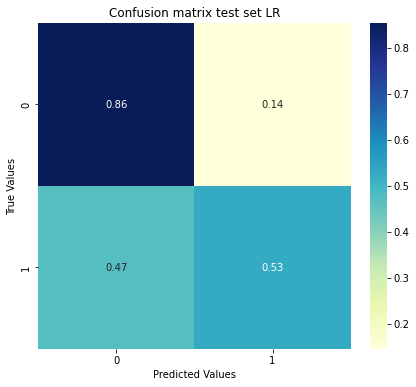

In [29]:
cm = confusion_matrix(y_test, pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.title("Confusion matrix test set LR")
plt.show(block=False)

Prediction only dominant class: ROC AUC=0.500
Model: ROC AUC=0.692


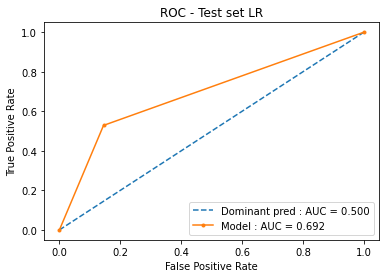

In [30]:
lr_probs = pred
#lr_probs = cv.best_estimator_.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Prediction only dominant class: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dominant pred : AUC = %.3f' % (ns_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model : AUC = %.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc = 'lower right')
pyplot.title("ROC - Test set LR")
# show the plot
pyplot.show()